## Finding Lane Lines 

In [7]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


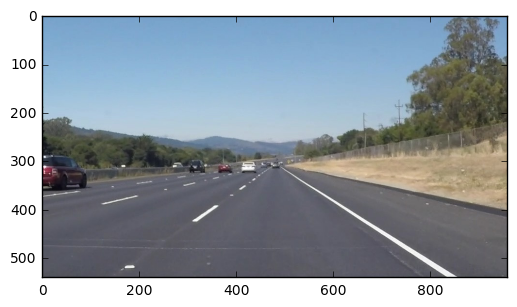

In [3]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [4]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=8):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    m1= []
    m2 = []
    b1 = []
    b2 = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            s = ((y2-y1)/(x2-x1))
            if  (s<-0.65) and (s >-0.85): 
                    m1.append(s)
                    b1.append(y2- (s*x2))
            elif (s<0.7) and (s> 0.5):
                m2.append(s)
                b2.append (y2-((s)*x2)) 
#   m1 = sum(a)/len(a) #negative
#   m2 = sum(a)/len(a) #positive               
 
    #For left lane
    try:
        m1_mean = sum(m1)/len(m1)
        b1_mean = sum(b1)/len(b1)
        y1, y2 = 325, 540
        x1,x2 = int((y1-b1_mean)/m1_mean),int((y2-b1_mean)/m1_mean)
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    except:
         ('skipping, error occured')
    
    # For right lane
    try:
        m2_mean = sum(m2)/len(m2)
        b2_mean = sum(b2)/len(b2)
        y1, y2 = 325, 540
        x1,x2 = int((y1-b2_mean)/m2_mean),int((y2-b2_mean)/m2_mean)
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    except:
         ('skipping, error occured')

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Building a lane Detection Pipeline:

First creating the pipeline on the test images and then moving on to videos

In [10]:
def Lanelinedetection_img(image):
    # NOTE: The output should be a color images (RGB, 3 channel) for processing video below
    
    # Step1: 
    # First coverting the image into grayscale
    gray = grayscale(image)
    
    # Step2: 
    # Define a kernel size for Gaussian smoothing / blurring
    # Note: this step is optional as cv2.Canny() applies a 5x5 Gaussian internally
    kernel_size = 5
    blur_gray = gaussian_blur(gray,kernel_size)
    
    # Define parameters for Canny and run it
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)
    imshape = edges.shape
    vertices = np.array([[(140,imshape[0]),(450, 325), (540, 320), (860,imshape[0])]], dtype=np.int32)
    
    # Step3: Keeping the region of interest i.e. regions defined by the polygon
    masked_edges = region_of_interest(edges,vertices)

    # Step4:
    # The Hough Transformation: from line space to Hough(point) space

    # Parameters
    # Make a blank the same size as our image to draw on
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 20 #minimum number of pixels making up a line
    max_line_gap =  60   # maximum gap in pixels between connectable line segments

    # Run Hough on edge detected image
    line_image = hough_lines(masked_edges, rho, theta,threshold,min_line_length,max_line_gap)

    #
    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges))
    
    # Draw the lines on the edge image
    lines_edges = weighted_img(line_image,image,.8,.9,10)
    
    return(lines_edges)

## Test on Images:

Running the code to detect lane lines for all images in the test folder and then make copies of that image and save them in the same folder

In [30]:
# images in the test folder
test_images = os.listdir("test_images/")
print(test_images)

['solidWhiteCurve.jpg', 'solidWhiteRight.jpg', 'solidYellowCurve.jpg', 'solidYellowCurve2.jpg', 'solidYellowLeft.jpg', 'whiteCarLaneSwitch.jpg']


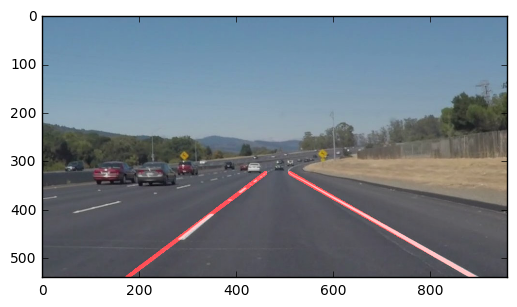

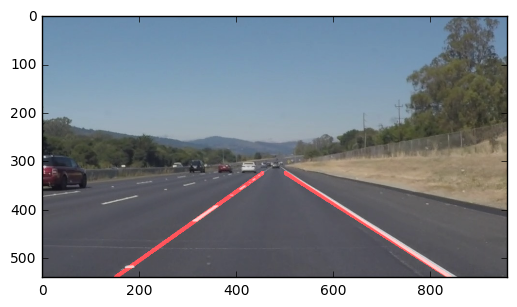

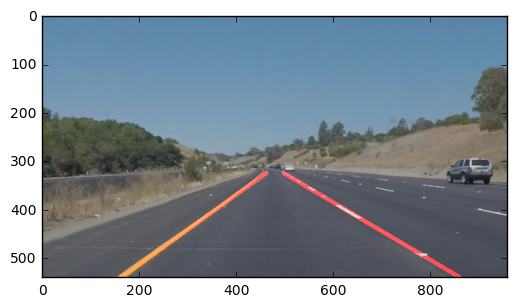

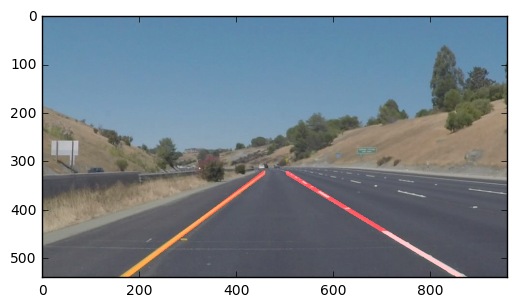

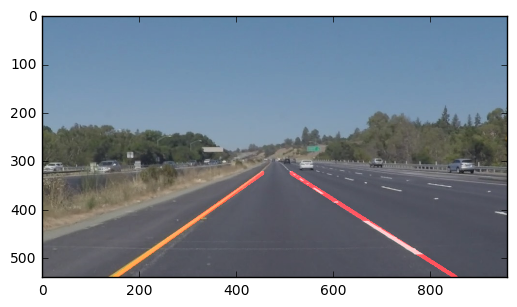

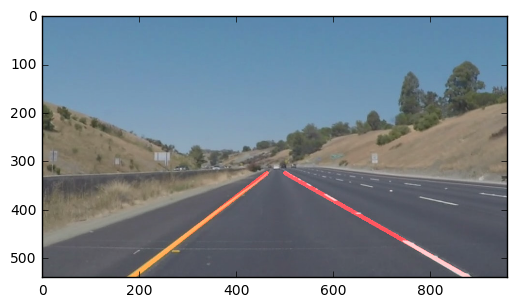

In [31]:
# Detecting lanes lines and 
for img in test_images:
    fullpath = "test_images/"+ img
    image = mpimg.imread(fullpath)
    out_image = Lanelinedetection_img(image)
    fname = img.split('.')[0] + '_lanedetected.jpg'
    # saving the images
    plt.imsave(os.path.join('test_images/', fname), out_image)
    plt.imshow(out_image)
    plt.show()

## Test on Videos

In [34]:
# first installing imageio
import imageio
imageio.plugins.ffmpeg.download()

Imageio: 'ffmpeg.osx' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg.osx (28.8 MB)
Downloading: 8192/30241064 bytes (0.0%)647168/30241064 bytes (2.1%)1646592/30241064 bytes (5.4%)2588672/30241064 bytes (8.6%)3514368/30241064 bytes (11.6%)5169152/30241064 bytes (17.1%)6119424/30241064 bytes (20.2%)7118848/30241064 bytes (23.5%)7987200/30241064 bytes (26.4%)9003008/30241064 bytes (29.8%)9871360/30241064 bytes (32.6%)10919936/30241064 bytes (36.1%)12034048/30241064 bytes (39.8%)13033472/30241064 bytes (43.1%)

In [36]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [37]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(Lanelinedetection_img) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:05<00:00, 37.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 2.76 s, sys: 777 ms, total: 3.54 s
Wall time: 6.73 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [38]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

### At this point, I am successfully able to detect lane lines on a video stream as well

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [39]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:19<00:00, 35.07it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 8.84 s, sys: 2.52 s, total: 11.4 s
Wall time: 20.2 s


In [40]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))
